<>:52: DeprecationWarning: invalid escape sequence '\O'
<>:52: DeprecationWarning: invalid escape sequence '\O'
/tmp/ipykernel_1355/1155610356.py:52: DeprecationWarning: invalid escape sequence '\O'
  axs[1].text(a/2, b*0.3, '$\Omega$', ha='center', va='center', fontsize=18, style='italic')


<Figure size 576x396 with 0 Axes>

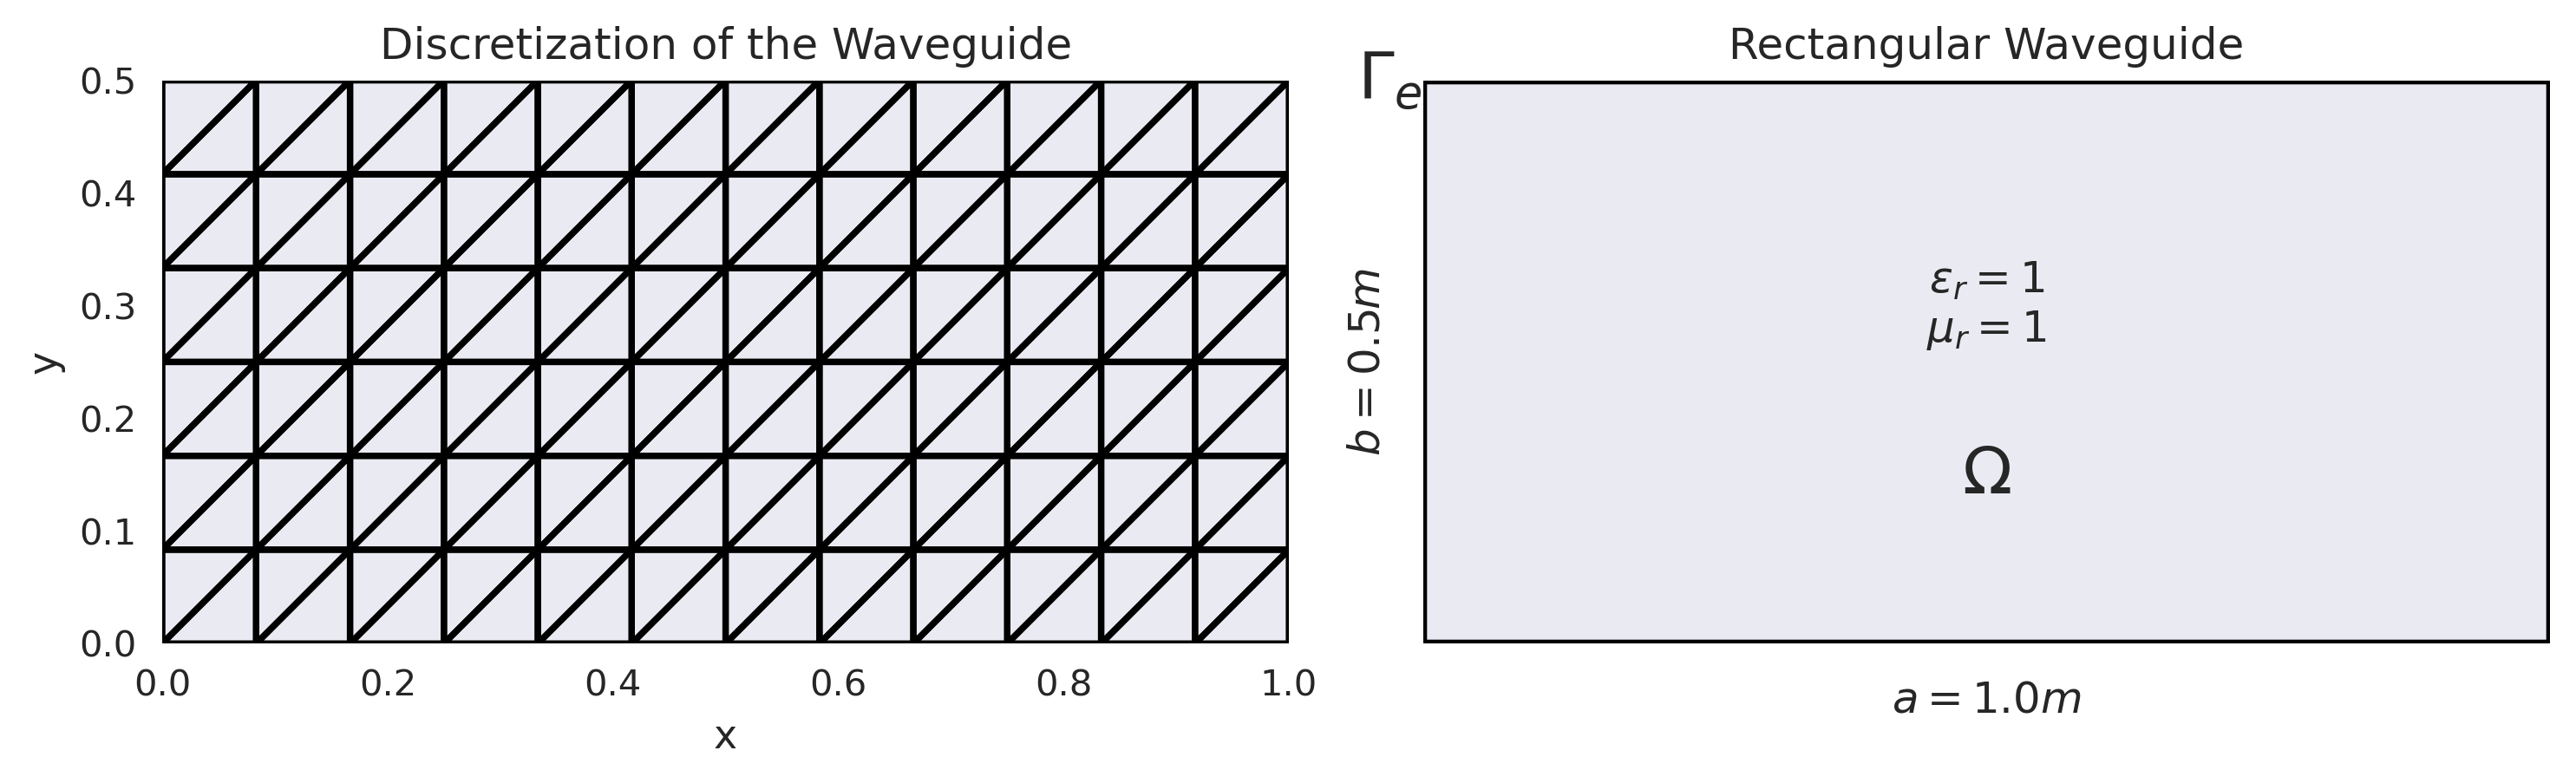

In [13]:
import matplotlib.pyplot as plt
from fenics import *
from matplotlib import patches
# Set the seaborn style for the whole figure
plt.style.use('seaborn')
# Define the mesh parameters
a, b = 1.0, 0.5  # Dimensions of the rectangle
mesh = RectangleMesh(Point(0, 0), Point(a, b), 12, 6)
facecolor = plt.gcf().get_facecolor()
# Extract the coordinates and cells (connectivity) of the mesh
coordinates = mesh.coordinates()
cells = mesh.cells()

# Define the corners of the waveguide
corners = [(0, 0), (a, 0), (a, b), (0, b)]

# Create the 1x2 subplot structure
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Plot the mesh in the first subplot
for cell in cells:
    x = [coordinates[vertex][0] for vertex in cell] + [coordinates[cell[0]][0]]
    y = [coordinates[vertex][1] for vertex in cell] + [coordinates[cell[0]][1]]
    axs[0].plot(x, y, 'k-')

# Set titles and axis labels for the mesh plot
axs[0].set_title("Discretization of the Waveguide")
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim([0, a])
axs[0].set_ylim([0, b])
axs[0].set_aspect('equal')
axs[0].grid(False)

for i in range(len(corners)):
    next_corner = corners[(i + 1) % 4]
    axs[1].plot([corners[i][0], next_corner[0]], [corners[i][1], next_corner[1]], 
                'k-', linewidth=2)

# Fill the rectangle with the same background color as the left subplot
axs[1].add_patch(patches.Rectangle((0, 0), a, b, linewidth=2, edgecolor='black', 
                                   facecolor='#eaeaf2'))

# Set the same limits and aspect ratio for the second subplot
axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_aspect('equal')
axs[1].axis('off')

# Add annotations to the second subplot
axs[1].text(a/2, b*0.6, '$\\varepsilon_r = 1$\n$\\mu_r = 1$', ha='center', va='center', fontsize=12)
axs[1].text(a/2, b*0.3, '$\Omega$', ha='center', va='center', fontsize=18, style='italic')
axs[1].text(a/2, -0.05, '$a = 1.0m$', ha='center', va='center', fontsize=12)
axs[1].text(-0.05, b/2, '$b = 0.5m$', ha='center', va='center', fontsize=12, rotation='vertical')
axs[1].text(-0.03, b , '$\\Gamma_e$', ha='center', va='center', fontsize=18)
axs[1].set_title("Rectangular Waveguide")

# Tight layout often improves the spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig('Figures/waveguide_subplot.eps', format='eps')

# Show the plot
plt.show()



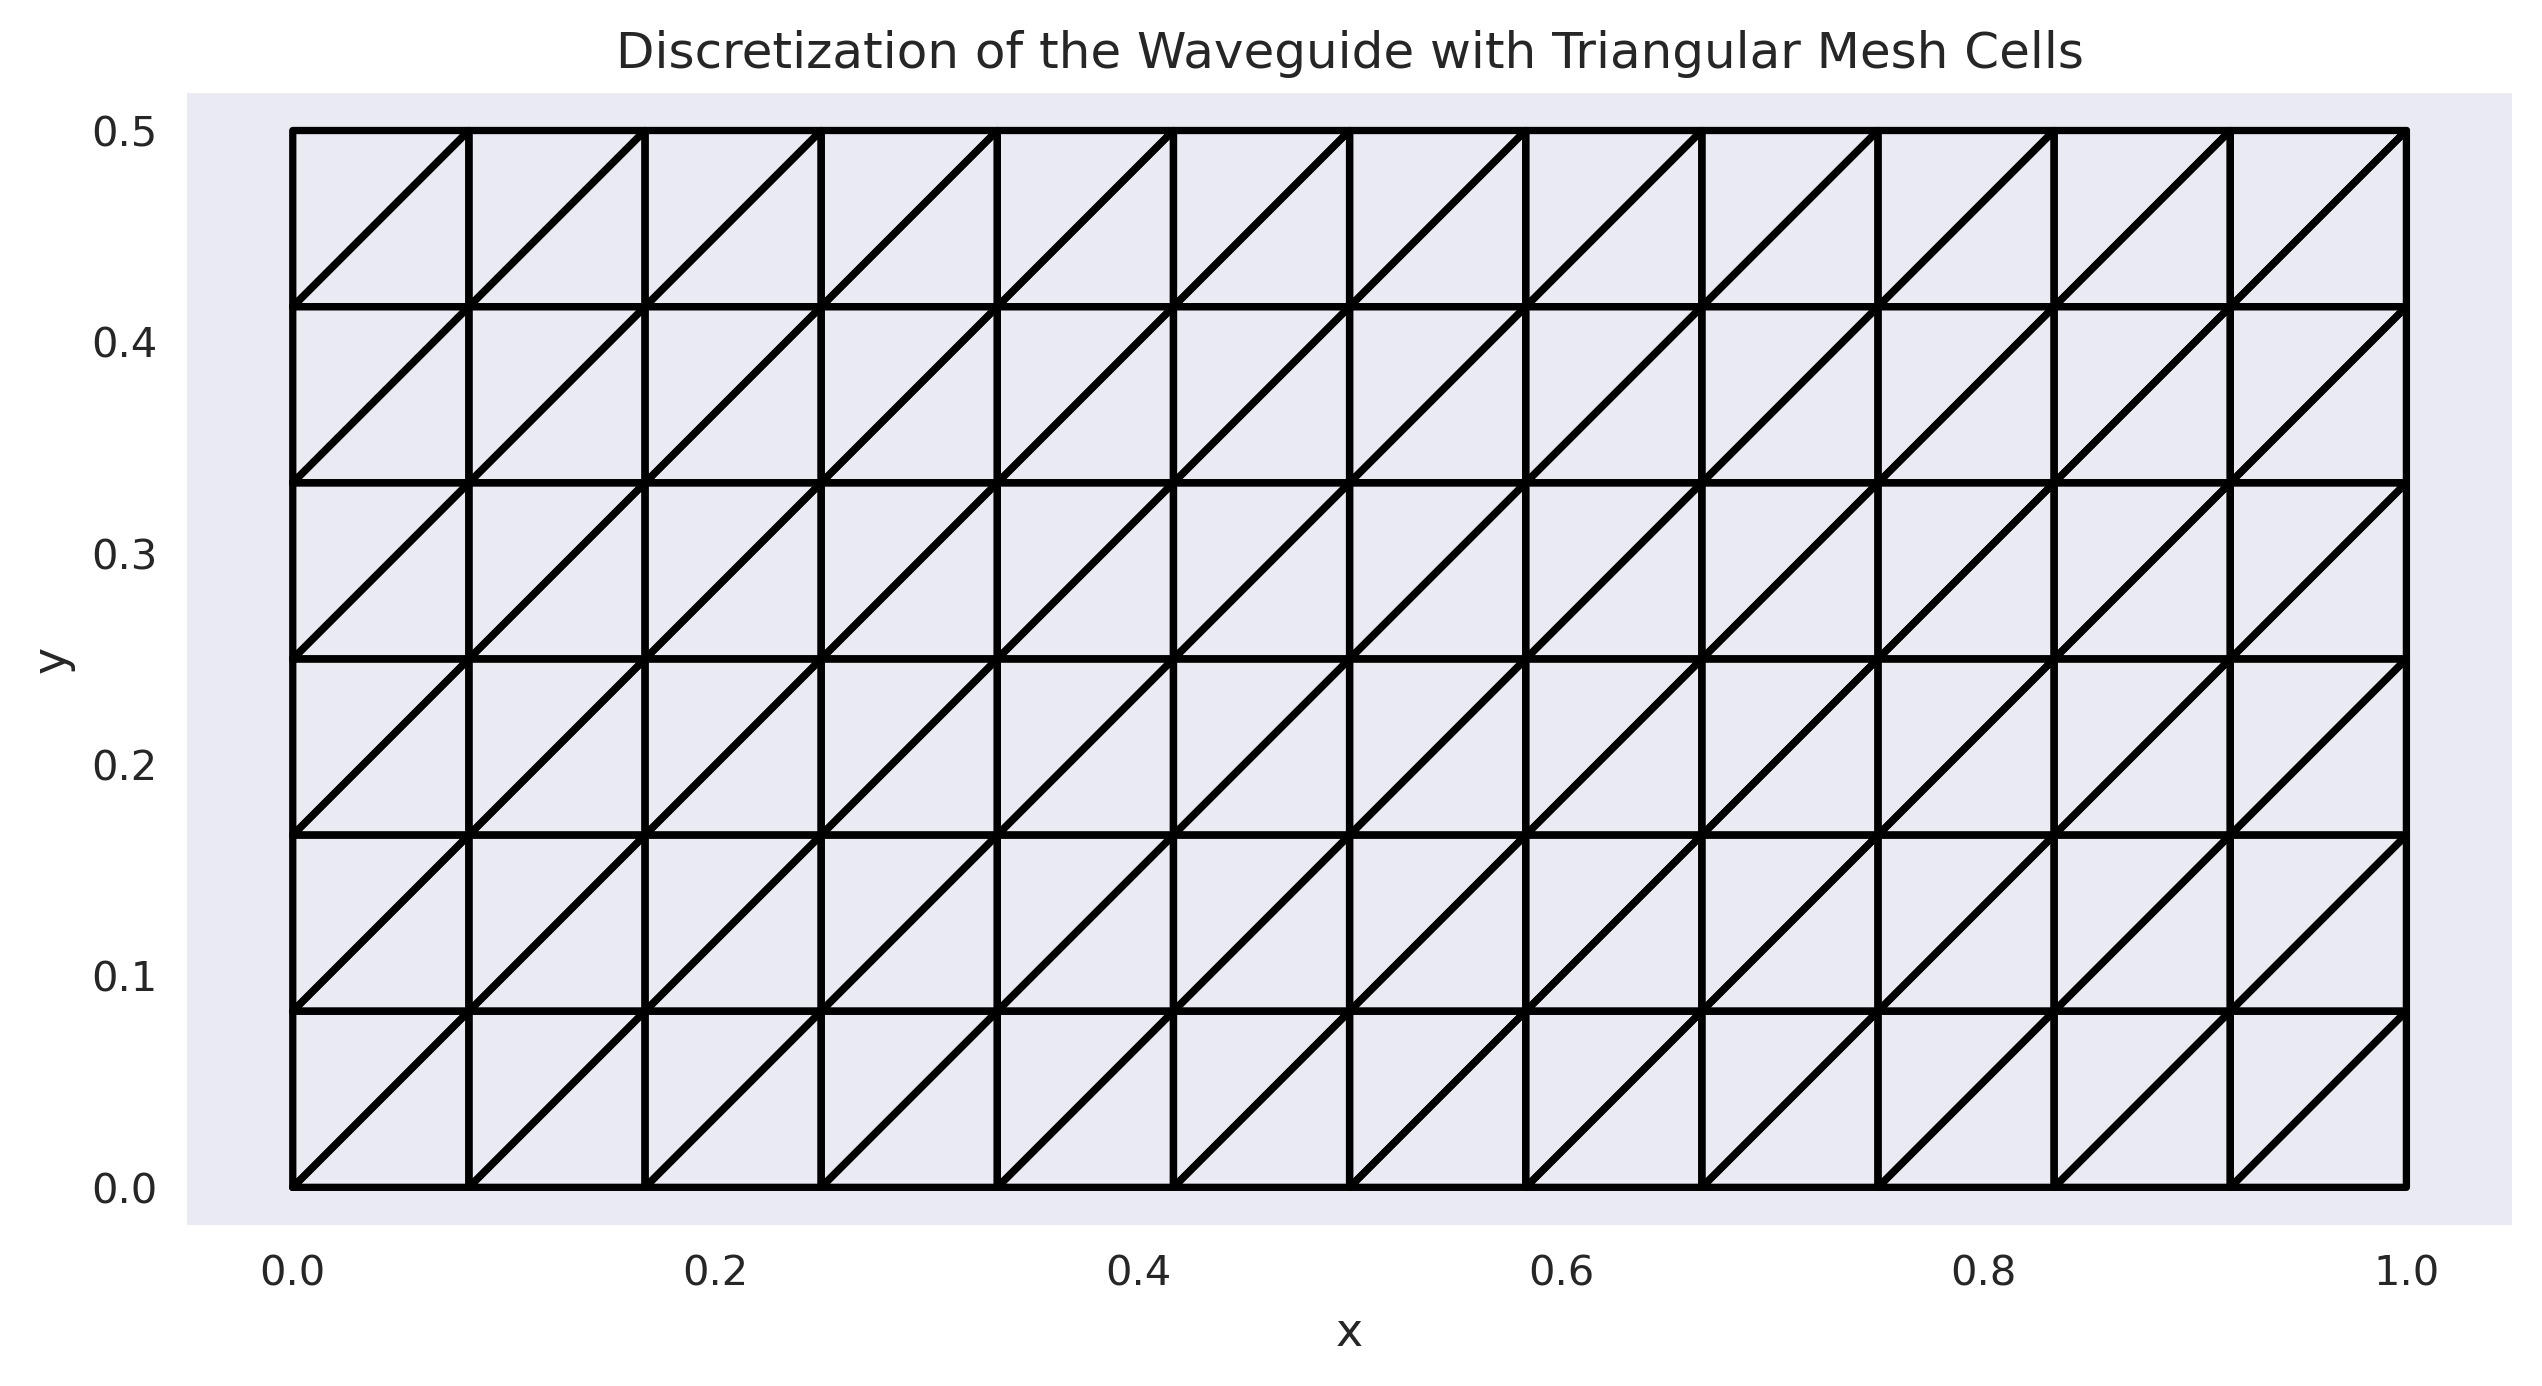

In [14]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr
plt.style.use('seaborn')
#The mesh used for the rectangular hollow waveguide
a = 1.0
b = 0.5

mesh = RectangleMesh(Point(0, 0), Point(a, b), 12, 6)

# Extract the coordinates and cells (connectivity) of the mesh
coordinates = mesh.coordinates()
cells = mesh.cells()

# Create a figure for plotting
plt.figure(figsize=(10, 5), dpi=300)  # High resolution
plt.title("Discretization of the Waveguide with Triangular Mesh Cells")

# Plot the mesh. Each row in `cells` defines a triangle in terms of indices into `coordinates`.
for cell in cells:
    x = [coordinates[vertex][0] for vertex in cell] + [coordinates[cell[0]][0]]
    y = [coordinates[vertex][1] for vertex in cell] + [coordinates[cell[0]][1]]
    plt.plot(x, y, 'k')

# Aesthetics
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')  # Equal aspect ratio
plt.grid(False)  # Turn off the grid as it's not usually aesthetic in mesh plots

# Save the figure
plt.savefig('waveguide_mesh.eps', format='eps')

# Show the plot
plt.show()




In [15]:
#define the orders of the function spaces for vector and nodal basis functions.
vector_order =2
nodal_order = 3

#Define the function spaces
vector_space = FunctionSpace(mesh, "N1curl", vector_order)
nodal_space = FunctionSpace(mesh, "Lagrange", nodal_order)
mixed_element = MixedElement([vector_space.ufl_element(), nodal_space.ufl_element()])
combined_space = FunctionSpace(mesh, mixed_element)

#define the test and trial functions from the combined space
(N_i,L_i) = TestFunctions(combined_space) 
(N_j,L_j) = TrialFunctions(combined_space)

#specify the relative permittivity and permeability
epsilon = Constant(1.0)
mu = Constant(1.0)

#define the forms for cutoff analysis to basis functions
s_tt_ij = 1.0/mu * inner(curl(N_i), curl(N_j))
t_tt_ij = epsilon*inner(N_i,N_j)
s_zz_ij = 1.0/mu * inner(grad(L_i), grad(L_j))
t_zz_ij = epsilon*inner(L_i,L_j)

#post-multiplication by dx will result in integration over the domain
s_ij = (s_tt_ij + s_zz_ij)*dx
t_ij = (t_tt_ij + t_zz_ij)*dx

#assemble the matrices
S = assemble(s_ij)
T = assemble(t_ij)

#create a mesh function to mark the edges (dimension 1 ) in the mesh.
boundary_markers = MeshFunction("size_t", mesh, 1)
print("here are the boundary markers")
print(boundary_markers.array)
boundary_markers.set_all(0)
DomainBoundary().mark(boundary_markers,1)

#Define the boundary conditions
electric_wall = DirichletBC(combined_space, Expression(("0,0","0,0","0,0"), degree=1), boundary_markers, 1)

#Apply the boundary conditions
electric_wall.apply(S)
electric_wall.apply(T)

#initialize a vector of ones 
indicators = np.ones(S.size(0))
indicators[list(electric_wall.get_boundary_values().keys())] = 0


free_dofs = np.where(indicators == 1)[0]

S_np = S.array()[free_dofs,:][:,free_dofs]
T_np = T.array()[free_dofs,:][:,free_dofs]

#solve the eigensystem using scipy.
from scipy.linalg import eig
k_c_squared,ev = eig(S_np,T_np)
sort_index = np.argsort(k_c_squared)
first_mode_idx = np.where(k_c_squared[sort_index] > 1e-8)[0][0]
# Mode definitions: TE10, TE01, TE20, TM11
mn_modes = [('TE', 1, 0), ('TE', 0, 1), ('TE', 2, 0), ('TM', 1, 1)]

# Analytical computation of the cutoff wavenumbers for the specified modes
analytical_kc = np.array([np.sqrt((m*np.pi/a)**2 + (n*np.pi/b)**2) if mode_type == 'TE' else
                          np.sqrt((m*np.pi/a)**2 + (n*np.pi/b)**2) for mode_type, m, n in mn_modes])

computed_kc = np.sqrt(k_c_squared[sort_index][first_mode_idx:first_mode_idx+4])

# Calculate errors
errors = np.abs(computed_kc - analytical_kc) / analytical_kc

# Printout in a tabular format
print("Mode\tAnalytical k_c\tComputed k_c\tError")
for i, ((mode_type, m, n), k_c_an, k_c_comp, err) in enumerate(zip(mn_modes, analytical_kc, computed_kc, errors)):
    mode_label = f"{mode_type}{m}{n}"
    # Ensure computed_kc is real-valued, as eig returns complex numbers
    k_c_comp_real = np.real(k_c_comp)
    print(f"{mode_label}\t{k_c_an:}\t{k_c_comp_real:}\t{err:}")

print("The cutoff wavenumber of the 4 most dominant modes are:")
print(np.real(k_c_squared[sort_index][first_mode_idx:first_mode_idx+4]))


mode_idx = 0

coefficients_global = np.zeros(S.size(0))
coefficients_global[free_dofs] = ev[:,sort_index[first_mode_idx+mode_idx]]
mode = Function(combined_space)

mode.vector().set_local(coefficients_global)

(TE, TM) = mode.split()

# Directly extract vertex values of the TE mode
values = TE.compute_vertex_values(mesh)

# Partition values into u and v components (assuming a 2D vector field)
num_vertices = len(values) // 2
u = values[:num_vertices]
v = values[num_vertices:]
coordinates = mesh.coordinates()
x = coordinates[:, 0]
y = coordinates[:, 1]
# Generate the quiver plot

# Calculate the magnitude of the vectors
magnitude = np.sqrt(u**2 + v**2)




here are the boundary markers
<bound method PyCapsule.array of <dolfin.cpp.mesh.MeshFunctionSizet object at 0x7fcda6cc64b0>>
Mode	Analytical k_c	Computed k_c	Error
TE10	3.141592653589793	3.1415931065643967	1.4418629451738837e-07
TE01	6.283185307179586	6.283199530894713	2.263774571530066e-06
TE20	6.283185307179586	6.283199543139293	2.2657233570364687e-06
TM11	7.024814731040727	7.02481694389466	3.1500530870989724e-07
The cutoff wavenumber of the 4 most dominant modes are:
[ 9.86960725 39.47859635 39.4785965  49.3480531 ]


/tmp/ipykernel_1355/3082787172.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  coefficients_global[free_dofs] = ev[:,sort_index[first_mode_idx+mode_idx]]


/tmp/ipykernel_1355/1875448413.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(quiver, orientation='vertical')


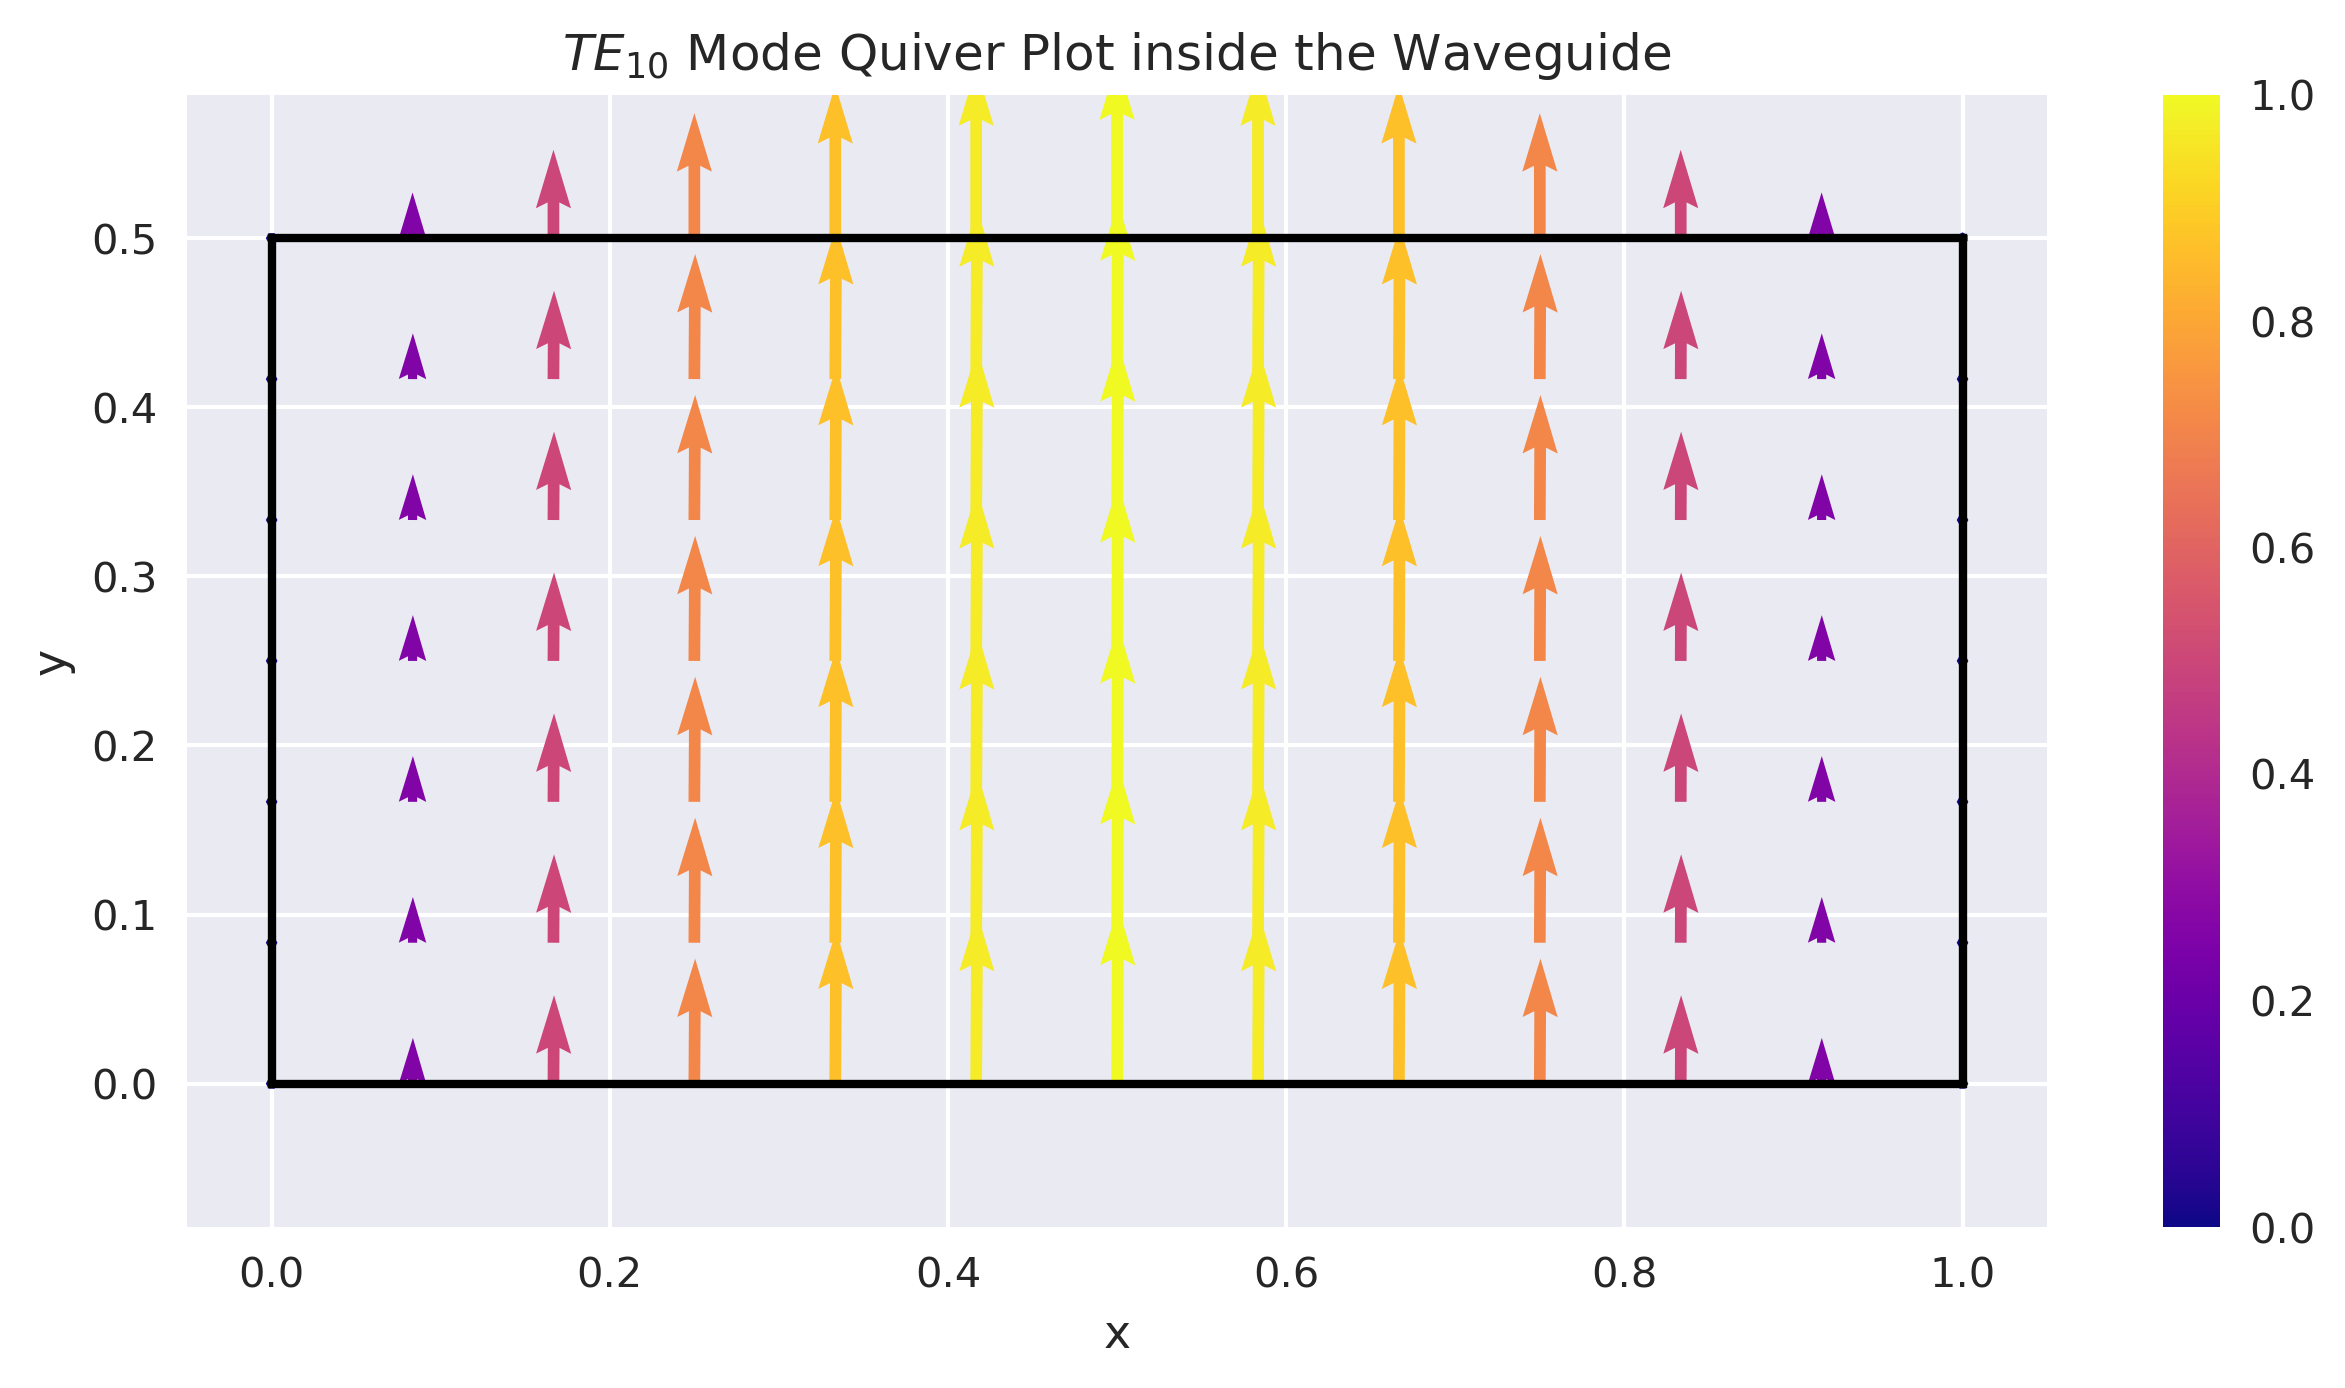

In [16]:

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
# Partition values into u and v components (assuming a 2D vector field)
num_vertices = len(values) // 2
u = -values[:num_vertices]  # Negate u component to flip horizontally
v = -values[num_vertices:]  # Negate v component to flip vertically

# Normalize the magnitude to be between 0 and 1
magnitude_normalized = magnitude / np.max(magnitude)

# Create the quiver plot
plt.figure(figsize=(10, 5), dpi=300)  # High resolution figure
quiver = plt.quiver(x, y, u, v, magnitude_normalized, cmap=cm.plasma)

# Add a colorbar based on the normalized magnitude
plt.colorbar(quiver, orientation='vertical')

# Get the limits of the waveguide based on the mesh coordinates
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

# Create a rectangle patch for the waveguide boundary
rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='black', facecolor='none')
plt.gca().add_patch(rect)

plt.title(r'$TE_{10}$ Mode Quiver Plot inside the Waveguide')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')  # Equal aspect ratio

# Save the figure as an EPS file
plt.savefig('TE_mode_quiver_plot_with_waveguide.eps', format='eps', dpi=300)

plt.show()

/tmp/ipykernel_1355/568510327.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  coefficients_global[free_dofs] = ev[:,sort_index[first_mode_idx+mode_idx]]
/tmp/ipykernel_1355/568510327.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(contourf_plot)


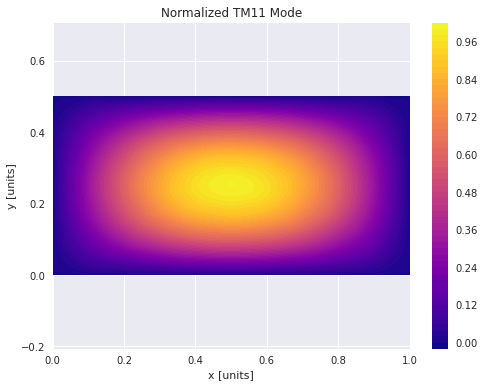

In [17]:
#import griddata from scipy.interpolate
from scipy.interpolate import griddata

mode_idx = 3

coefficients_global = np.zeros(S.size(0))
coefficients_global[free_dofs] = ev[:,sort_index[first_mode_idx+mode_idx]]
mode = Function(combined_space)

mode.vector().set_local(coefficients_global)

(TE, TM) = mode.split()


# Extract nodal values of the TM mode
TM_nodal_values = TM.compute_vertex_values(mesh)

# Normalize the values to be between 0 and 1
TM_nodal_values_normalized = (TM_nodal_values - np.min(TM_nodal_values)) / (np.max(TM_nodal_values) - np.min(TM_nodal_values))

# Get the coordinates of the mesh vertices
coordinates = mesh.coordinates()
x = coordinates[:, 0]
y = coordinates[:, 1]

# Create a grid for the interpolation
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), 100), 
                   np.linspace(np.min(y), np.max(y), 100))

# Interpolate the normalized values onto the grid
TM_interp_normalized = griddata((x, y), TM_nodal_values_normalized, (X, Y), method='cubic')

# Now you can plot using matplotlib's contourf function for a filled contour plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
contourf_plot = plt.contourf(X, Y, TM_interp_normalized, levels=50, cmap='plasma')
plt.colorbar(contourf_plot)
plt.title('Normalized TM11 Mode')
plt.xlabel('x [units]')
plt.ylabel('y [units]')
plt.axis('equal')  # To keep the scale of x and y the same
plt.show()



/tmp/ipykernel_1355/3458732568.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(quiver, ax=axs[0], orientation='vertical')
/tmp/ipykernel_1355/3458732568.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(contourf_plot, ax=axs[1])


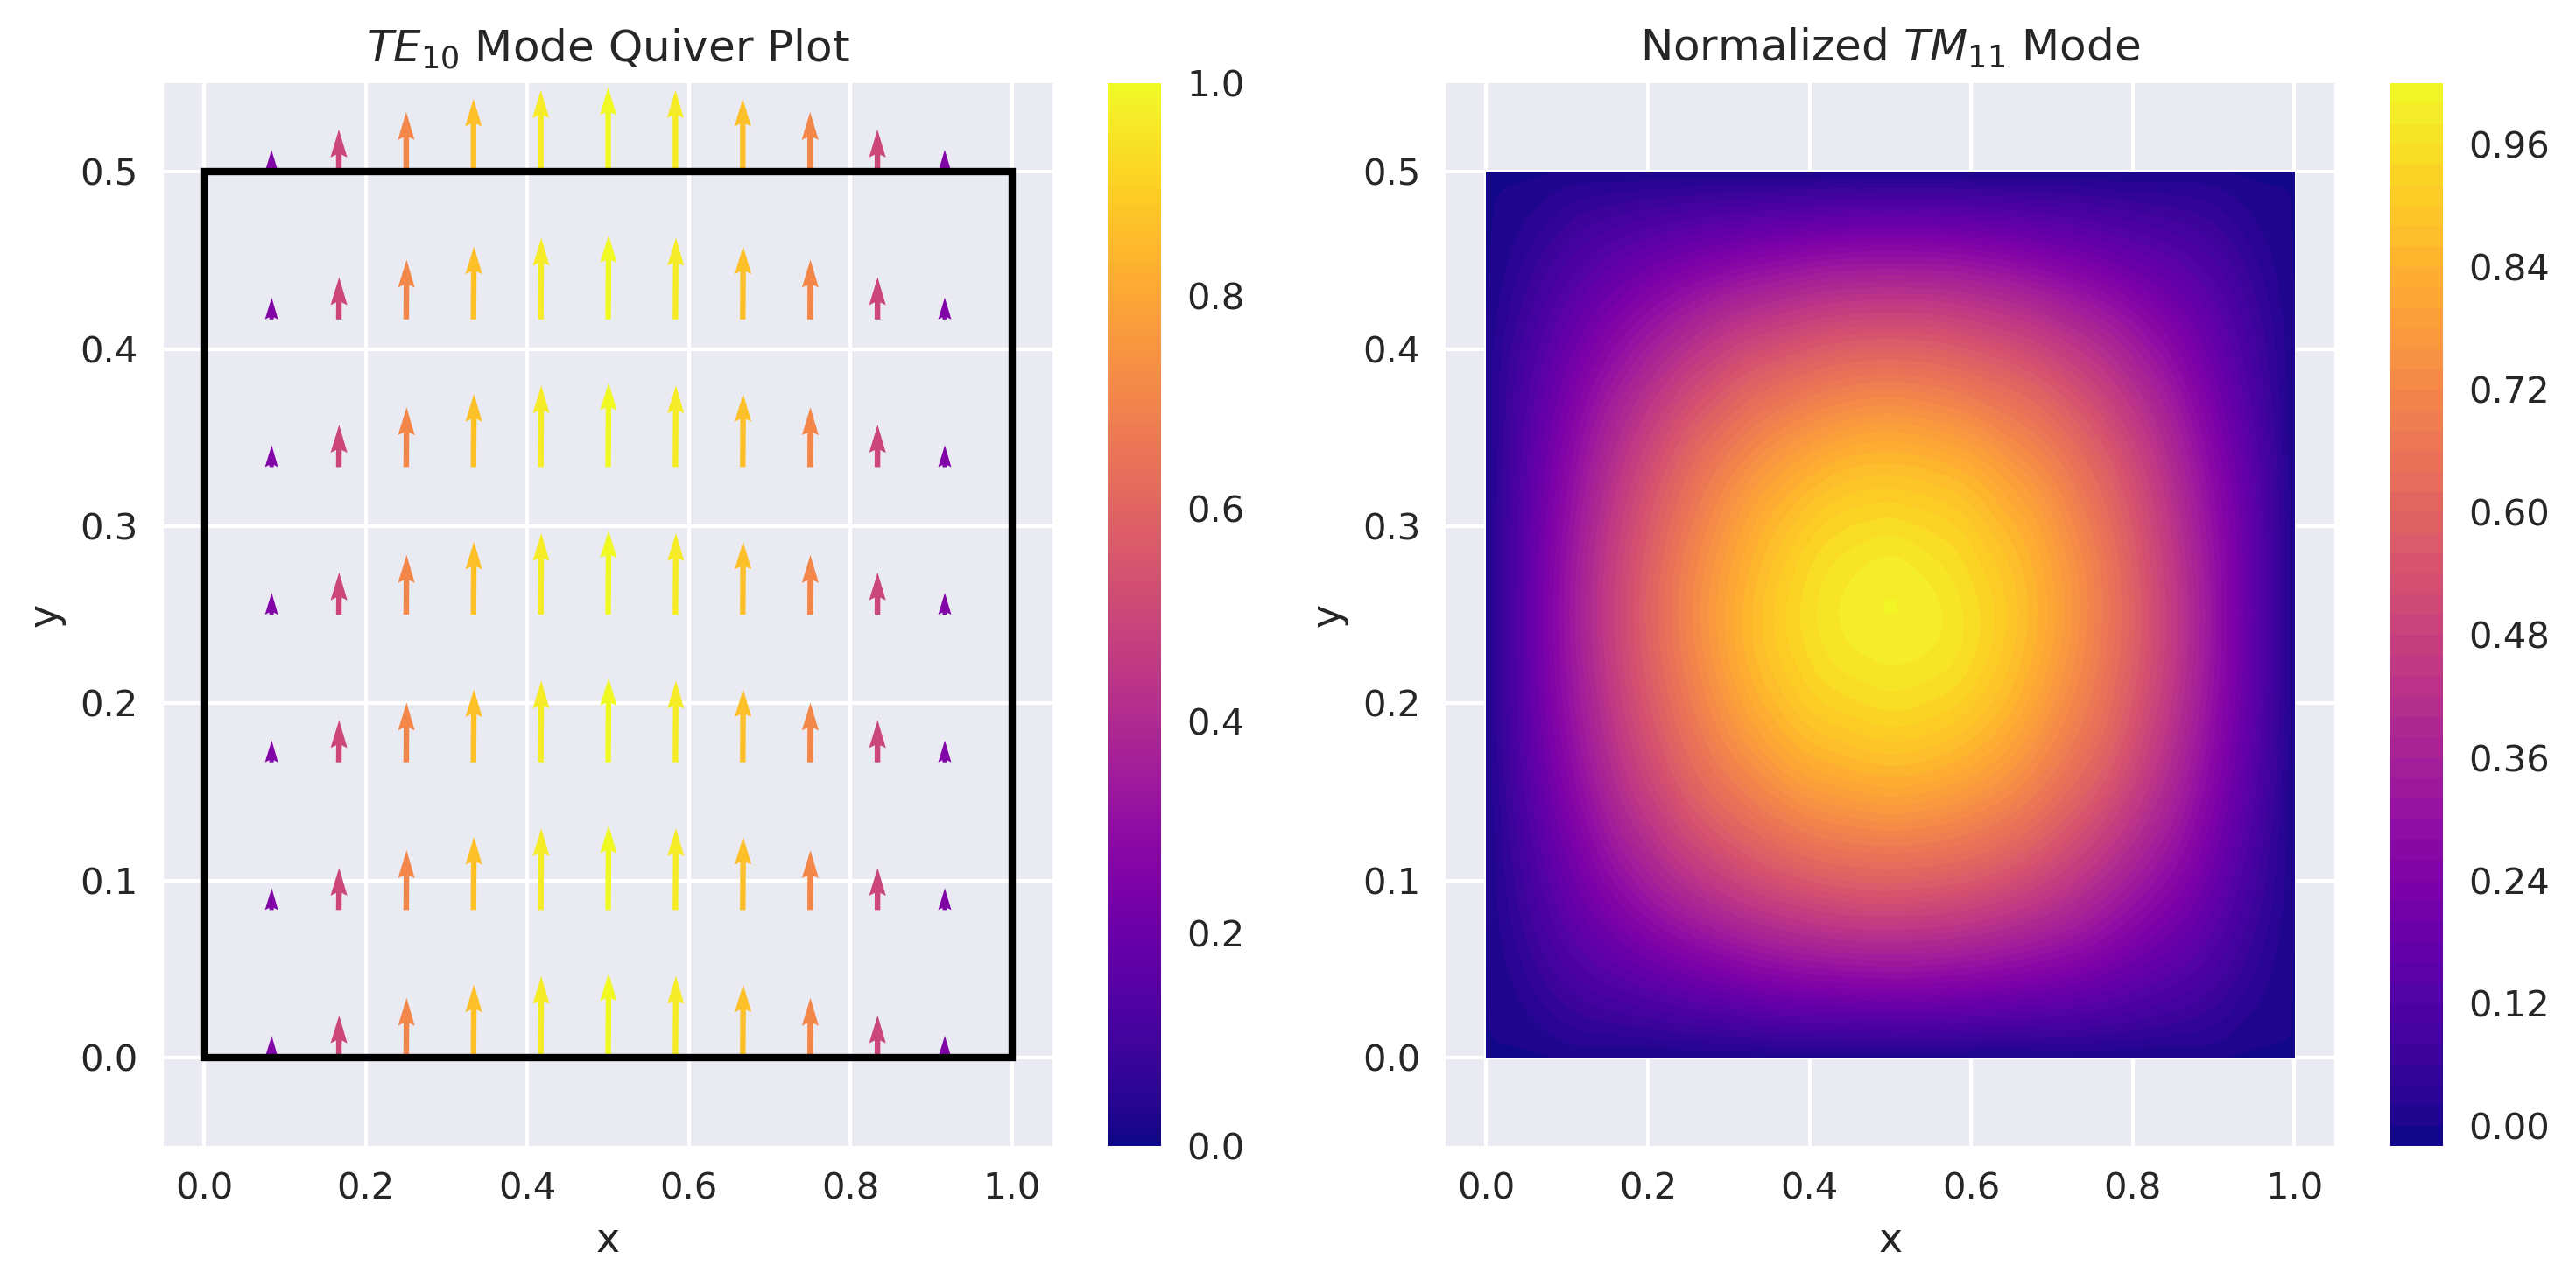

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle

# Set up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)  # 1 row, 2 columns

# First subplot - Quiver plot
quiver = axs[0].quiver(x, y, u, v, magnitude_normalized, cmap=cm.plasma)
fig.colorbar(quiver, ax=axs[0], orientation='vertical')


# Set the limits for the contour plot
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_ylim(-0.05, 0.55)


# Create a rectangle patch for the waveguide boundary in the quiver plot
rect = Rectangle((0, 0), 1, 0.5, linewidth=2, edgecolor='black', facecolor='none')
axs[0].add_patch(rect)

axs[0].set_title(r'$TE_{10}$ Mode Quiver Plot')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Second subplot - Contour plot
contourf_plot = axs[1].contourf(X, Y, TM_interp_normalized, levels=50, cmap='plasma')
fig.colorbar(contourf_plot, ax=axs[1])

# Set the limits for the contour plot
axs[1].set_xlim(-0.05, 1.05)
axs[1].set_ylim(-0.05, 0.55)

axs[1].set_title(r'Normalized $TM_{11}$ Mode')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Adjust layout to minimize whitespace
plt.tight_layout()

# Save the figure as an EPS file
plt.savefig('combined_TE_TM_modes.eps', format='eps', dpi=300)

plt.show()
